In [1]:
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import torch.nn.functional as F
import torch.nn.init as init
import torch

### Вариант 1
**Цель:** Контроль дисперсии весов.
- Разработайте архитектуру, которая будет за **5 слоев** приводить тензор к размерности `(1, 512, 1, 1)`.
- **Условие:** дисперсия весов третьего слоя должна быть в **два раза больше**, чем у второго и четвертого.
- **Эксперимент:** Проверьте влияние увеличенной дисперсии третьего слоя на распределение активаций после GAP и визуализируйте их гистограмму.

In [2]:
class CNN_1(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)

    def forward(self, x):

        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = F.relu(self.conv_3(x))
        x = F.relu(self.conv_4(x))
        x = F.relu(self.conv_5(x))

        x = F.adaptive_avg_pool2d(x, 1)
        return x

model = CNN_1(3)
test_tensor = torch.randn(1, 3, 32, 32)
out = model(test_tensor)
print(out.shape)

torch.Size([1, 512, 1, 1])


In [3]:
def initialize_weights(model, main_std = 0.4, target_layer = 2, condition = False):
    i = 0

    for m in model.modules():
        std = main_std

        if isinstance(m, nn.Conv2d):

            if i == target_layer and condition == True:
                std *= np.sqrt(2)

            nn.init.normal_(m.weight, mean = 0, std = std)
            
            if m.bias is not None:
                init.constant_(m.bias, 0)

            print(f'Диспесрия {i+1} слоя: {std**2:.5f}')
            i += 1

In [4]:
models = [CNN_1(3), CNN_1(3)]
print('Инициализация весов первой модели')
initialize_weights(model = models[0], main_std = 0.5, condition = False)
print('Инициализация весов второй модели')
initialize_weights(model = models[1], main_std = 0.5, target_layer = 2, condition=True)


Инициализация весов первой модели
Диспесрия 1 слоя: 0.25000
Диспесрия 2 слоя: 0.25000
Диспесрия 3 слоя: 0.25000
Диспесрия 4 слоя: 0.25000
Диспесрия 5 слоя: 0.25000
Инициализация весов второй модели
Диспесрия 1 слоя: 0.25000
Диспесрия 2 слоя: 0.25000
Диспесрия 3 слоя: 0.50000
Диспесрия 4 слоя: 0.25000
Диспесрия 5 слоя: 0.25000


In [5]:
def plot_activation_distributions(test_tensor, models):
    """Распределения активаций"""
    outputs = []

    with torch.no_grad():
        for model in models:
            outputs.append(model(test_tensor))

    fig, axs = plt.subplots(1, len(models), figsize=(12, 4))
    for i, data in enumerate(outputs):
        arr = data.cpu().numpy().flatten()
        axs[i].hist(arr, bins=50)
        axs[i].set_title(f"Модель {i+1} \nmean={arr.mean():.4f}, std={arr.std():.4f}")
        axs[i].grid() 
               
    plt.tight_layout()
    plt.show()

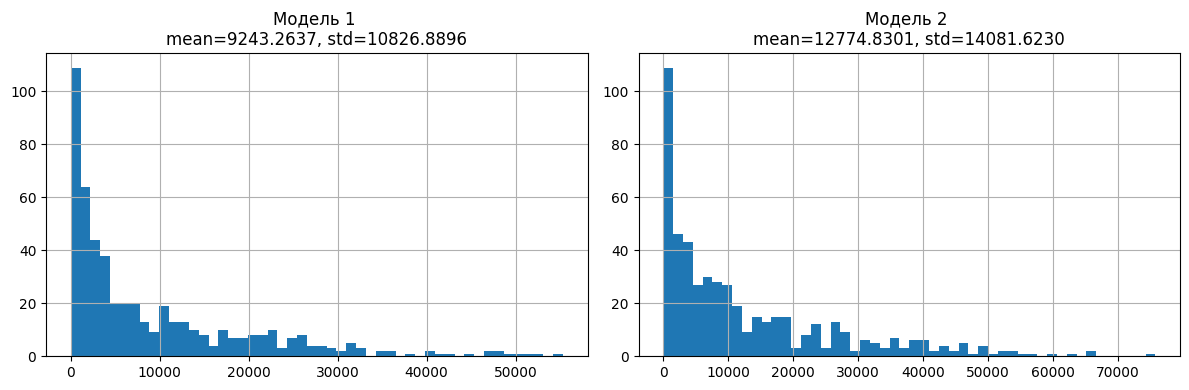

In [6]:
test_tensor = torch.randn(1, 3, 32, 32)
plot_activation_distributions(test_tensor=test_tensor, models=models)

В результате увеличения дисперсии третьего слоя мы наблюдаем:
- более агрессивные значения
- увеличенное среднее значение
- более вытянутое распределение активаций 
- больше нейронов включается с разной интенсивностью
- повышенная чувствительность к малозаметным паттернам

Если не сбалансировать веса, то в последствии может возникнуть эффект взрыва градиентов (слишком большие веса → активации и градиенты растут без контроля)


---
### Вариант 5. Контроль градиентов через глубину
**Цель:** Изучение поведения градиентов в глубокой сети.
- Разработайте сеть с **не менее 6 слоев**, которая выводит тензор `(batch, 64, 8, 8)`.
- **Условие:** Слои должны чередоваться между `Conv2d` и `ReLU`, при этом **градиенты первого слоя должны быть меньше градиентов последнего** после одной итерации `backward()` на случайных данных.
- **Эксперимент:** Визуализируйте градиенты по слоям и объясните, почему градиенты убывают или растут.

In [24]:
class CNN_2(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride = 2, padding=1)
        self.conv_5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride = 2, padding=1)
        self.conv_6 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = self.relu(self.conv_4(x))
        x = self.relu(self.conv_5(x))
        x = self.relu(self.conv_6(x))

        return x

model = CNN_2(3)
test_tensor = torch.randn(1,3,64,64)
out = model(test_tensor)
print(out.shape)

torch.Size([1, 64, 8, 8])


In [25]:
test_tensor = torch.randn(1,3,64,64, requires_grad=True)
y_true = torch.randn(1,64,8,8, requires_grad=True)

y_pred = model(test_tensor)

In [26]:
# вычисление ошибки 
criterion = nn.CrossEntropyLoss()
loss = criterion(y_pred, y_true)

print(loss)

tensor(0.5251, grad_fn=<DivBackward1>)


In [27]:
# бэкпропагейшн - посчитает для всех весов градиенты
loss.backward()

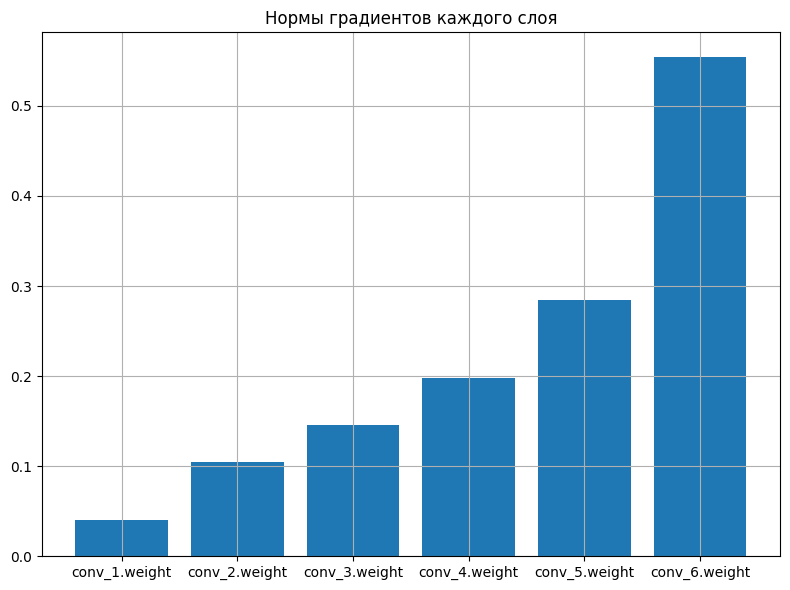

In [33]:
def plot_gradients(model):
    grad_norm = []
    names = []
    
    for name, param in model.named_parameters():
        # Собираем только веса Conv2d
        if 'weight' in name:

            # Норма градиента
            grad_norm.append(param.grad.norm().item())
            names.append(name)
    
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(grad_norm)), grad_norm)
    plt.xticks(range(len(grad_norm)), names)
    plt.title('Нормы градиентов каждого слоя')
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_gradients(model)

Градиенты первого слоя меньше градиентов после одной итерации на случайных данных


In [55]:
def plot_gradients_distribution(model):
    layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6']
    gradients = []

    for name, param in model.named_parameters():
        if 'weight' in name:
            gradients.append(param.grad)


    for i, grad in enumerate(gradients):
        plt.figure()
        plt.title(f"Рапределение градиентов для {layer_names[i]}")
        plt.hist(grad.detach().numpy().flatten(), bins=50)
        plt.xlabel("Градиенты")
        plt.ylabel("Частота")
        plt.grid()
        plt.show()

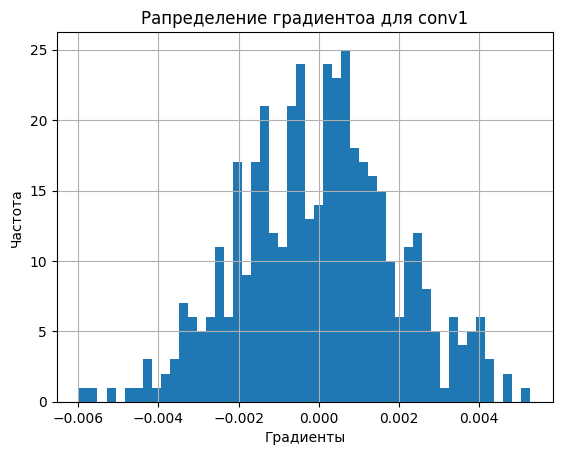

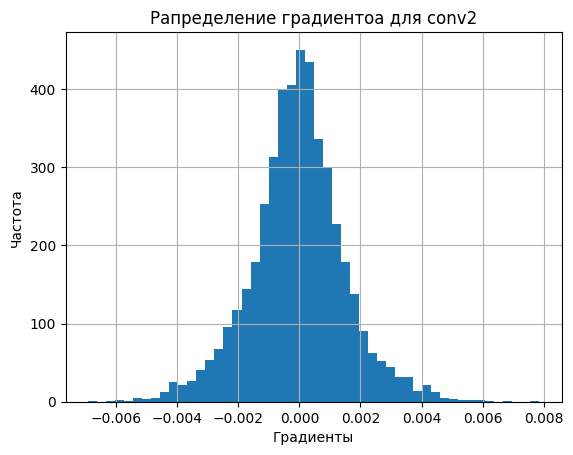

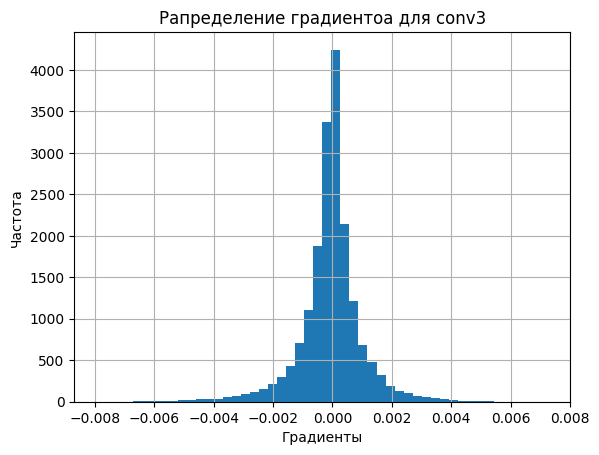

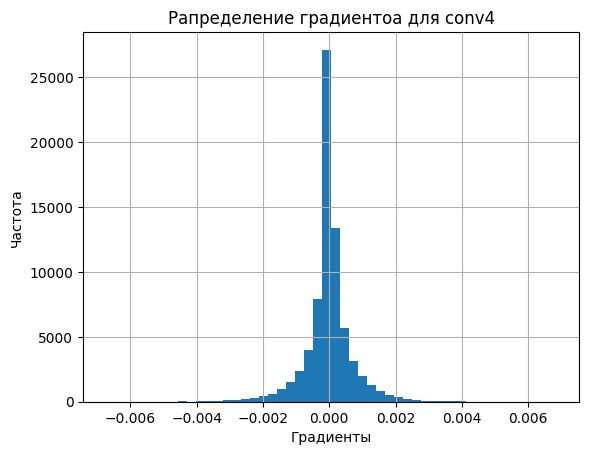

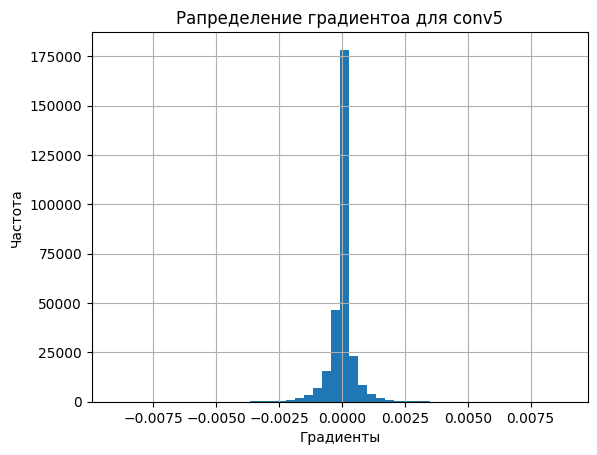

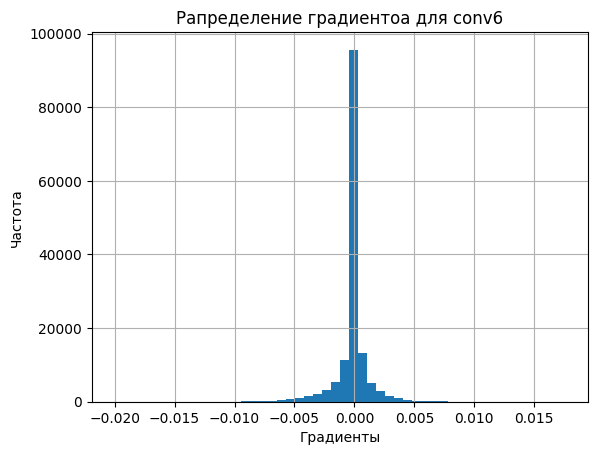

In [53]:
plot_gradients_distribution(model)

- Наблюдается экспонетиацльный рост нормы градиента, обусловленный накопительным эффектом 
- наблюдается уменьшение разброса градиентов после каждого слоя
- использование функции активации ReLU усиливает значения градиентов на выходе 
